# Installing Openfermion

1. Open a folder
2. Clone repo via git: `git clone https://github.com/quantumlib/OpenFermion`
3. Go to cloned folder: `cd OpenFermion`
4. Install with pip: `python3 -m pip install -e .`

# Planewave Hamiltonian

`plane_wave_hamiltonian` function returns the hamiltonian of the system in the plane-wave basis as a FermionOperator.

We need to pass a `Grid` and a `geometry` to this function.

In [1]:
from openfermion import plane_wave_hamiltonian

## Grid

Grid needs 3 arguments: `dimensions, length, scale`

`dimensions (int)`: The number of dimensions the grid lives in.

`length (int or tuple)`: The number of points along each grid axis
                that will be taken in both reciprocal and real space.
                If tuple, it is read for each dimension, otherwise assumed
                uniform.
                
`scale (float or ndarray)`: The total length of each grid dimension.
    If a float is passed, the uniform cubic unit cell is assumed.
    For an ndarray, dimensions independent vectors of the correct
    dimension must be passed.  We assume column vectors define
    the supercell vectors.

In [2]:
from openfermion.utils import Grid

grid = Grid(1, 2, 1.0) # We are working in 1D.

## Geometry

A list of tuples giving the coordinates of each atom. 

Distances in angstrom. Use atomic symbols to specify atoms.

Example for 3D geometry is [('H', (0, 0, 0)), ('H', (0, 0, 0.7414))]. 

For 1D: [('H', (0,)), ('H', (0.7414,))]


In [3]:
geometry = [('H', (0,)), ('H', (0.7414,))]

In [4]:
pwh = plane_wave_hamiltonian(grid,geometry)
pwh

19.739208802178716 [0^ 0] +
0.15915494309189535 [0^ 1^ 3 2] +
(-0.30111825512336843+1.843817536508347e-17j) [0^ 2] +
0.15915494309189535 [0^ 2^ 0 2] +
0.15915494309189535 [0^ 3^ 1 2] +
0.15915494309189535 [1^ 0^ 2 3] +
19.739208802178716 [1^ 1] +
0.15915494309189535 [1^ 2^ 0 3] +
(-0.30111825512336843+1.843817536508347e-17j) [1^ 3] +
0.15915494309189535 [1^ 3^ 1 3] +
(-0.30111825512336843-1.843817536508347e-17j) [2^ 0] +
0.15915494309189535 [2^ 0^ 2 0] +
0.15915494309189535 [2^ 1^ 3 0] +
0.15915494309189535 [2^ 3^ 1 0] +
0.15915494309189535 [3^ 0^ 2 1] +
(-0.30111825512336843-1.843817536508347e-17j) [3^ 1] +
0.15915494309189535 [3^ 1^ 3 1] +
0.15915494309189535 [3^ 2^ 0 1]

## Finding Ground State

### Jordan Wigner Transformation

First, we need to transform our Hamiltonian (FermionOperator) to Qubit Operator with `jordan_wigner` transformation. Then, we use compress function to get rid of the zero values.

In [5]:
from openfermion.transforms import jordan_wigner

jw = jordan_wigner(pwh)
jw.compress()

jw

19.580053859086824 [] +
-0.07957747154594767 [X0 X1 Y2 Y3] +
0.07957747154594767 [X0 Y1 Y2 X3] +
-0.15055912756168421 [X0 Z1 X2] +
0.07957747154594767 [Y0 X1 X2 Y3] +
-0.07957747154594767 [Y0 Y1 X2 X3] +
-0.15055912756168421 [Y0 Z1 Y2] +
-9.790026929543409 [Z0] +
-0.07957747154594767 [Z0 Z2] +
-0.15055912756168421 [X1 Z2 X3] +
-0.15055912756168421 [Y1 Z2 Y3] +
-9.790026929543409 [Z1] +
-0.07957747154594767 [Z1 Z3] +
0.07957747154594767 [Z2] +
0.07957747154594767 [Z3]

### Sparse Operator

We need sparse operator of the Qubit Operator.

In [6]:
from openfermion import get_sparse_operator

sparse_jwham  = get_sparse_operator(jw)
sparse_jwham

<16x16 sparse matrix of type '<class 'numpy.complex128'>'
	with 36 stored elements in Compressed Sparse Column format>

### Ground State

`get_ground_state` function returns the minimum eigenvalue and the minimum eigenstate of the sparse operator 

In [7]:
from openfermion.linalg import get_ground_state

gs = get_ground_state(sparse_jwham)[0]
gs

-0.011458757929299769

# Finding Ground States for different distances

## Functions

In [8]:
def getGroundState(op):
    jw = jordan_wigner(op)
    jw.compress()
    sparse_jwham  = get_sparse_operator(jw)
    return get_ground_state(sparse_jwham)[0]

In [9]:
def pwGroundState(dim,length,scale,dist):
    grid = Grid(dim,length,scale)

    geometry = [("H",(0,)*dim),("H",(0,)*(dim-1) + (dist,))] # distance is on the z-axis

    pwh = plane_wave_hamiltonian(grid,geometry)
    gs = getGroundState(pwh)
    return gs

In [10]:
import numpy as np

In [11]:
def incDist(start,stop,npoints,dim,length,scale):
    npoints = 50
    dists = np.linspace(start,stop,npoints)

    energies = [pwGroundState(dim,length,scale,dist) for dist in dists]

    return dists,energies

In [19]:
inc1d = incDist(0,3,45,1,2,1.0)

In [12]:
import matplotlib.pyplot as plt

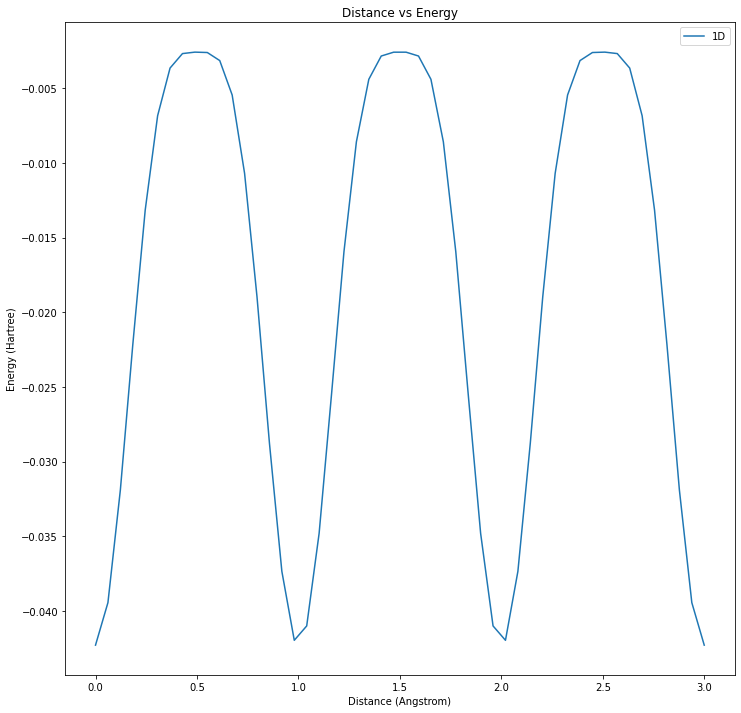

In [20]:
plt.figure(figsize=(12,12))
plt.plot(*inc1d,label="1D")
plt.title("Distance vs Energy")
plt.xlabel("Distance (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()